# Computer Vision and CNN's!

If you can see it, it can probably be turned into a computer vision problem

* Classification
* Object Detection
* Segmentation (Computational photography) `On-device Panoptic Segmentation for Camera Using Transformers` - Apple Machine Learning Research
* Tesla 8 cameras -> 3D 'Vector Space'
* DensePose

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. | 
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. | 
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  | 
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iteralbe over a dataset (created with `torch.utils.data.Dataset`). 

## What is a Convolutional Neural Network?
### Architecture of a CNN
| Hyperparameter/Layer Type | What does it do? | Typical Values|
| ------ | ------ | -------|
| Input Image(s) | Target images you'd like to discover patterns in | Whatever you can take a photo (or video) of. |
| Input Layer | Takes in target images and preprocesses them for further layers | input_shape = [batch_size, img_height, img_width, color_channels] (channels last) or input_shape = [batch_size, color_channels, img_height, img_width] (channels first) |
| Convolution Layer | Exctracts/learns the most important faetures from target images | Multiple, can create with torch.nnConvXd() |
| Hidden activation/non-linear activation | Adds non-linearity to learned features | Usually ReLU |
| Pooling Layer | Reduces the dimensionality of learned image features | Max (torn.nn.MaxPool2d()) or Average (torhc.nn.AvgPool2d()) |
| Output Layer/Linear Layer | Takes learned features and outputs them in shape of target labels | torch.nn.Linear() |
| Output activation | Converts out put logits to prediction probabilities | torhc.sigmoid() for bianry classification or torch.softmax() for multi-class classification |


### PyTorch Computer Vision

Vision Libraries in PyTorch
* [`torchvision`] - base domain library for PyTorch computer vision
* [`torchvision.datasets`] - get datasets and data loading functions for computer vision here
* [`torchvision.models`] - get pretrained computer vision models that you can leverage for your own problems
* [`torchvision.transforms`] - functions for manipulating yourvision data to bhe suitable for use with PyTorch
* [`torch.utils.data.Dataset`] - Base dataset class for PyTorch
* [`torch.utils.data.DataLoader`] - Creats a Python iterable over a dataset

In [2]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy

RAND_SEED = 2697
LR = 1e-3
EPOCHS = 0

device = torch.device("cpu")

print(torch.__version__)
print(torchvision.__version__)

device

/home/chunt/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.0.1+cu117
0.15.2+cu117


device(type='cpu')

### 1. Getting a dataset

This project will develop a multi-class classification model that takes the FashionMNIST dataset and trains a CNN to recognize what type of clothing is being displayed.

FashionMNIST is located in torch.datasets

So you download the dataset and then wrap it into a dataloader.


In [3]:
train_dataset = datasets.FashionMNIST(root="data",
                                      train=True,
                                      download=True,
                                      transform=ToTensor(),
                                      target_transform=None)
test_dataset = datasets.FashionMNIST(root="data",
                                     train=False,
                                     download=True,
                                     transform=ToTensor(),
                                     target_transform=None)


100%|██████████| 26421880/26421880 [01:27<00:00, 301635.44it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144642.66it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:14<00:00, 298018.25it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19193135.10it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



data[0].shape: torch.Size([28, 28])
Target : Ankle boot


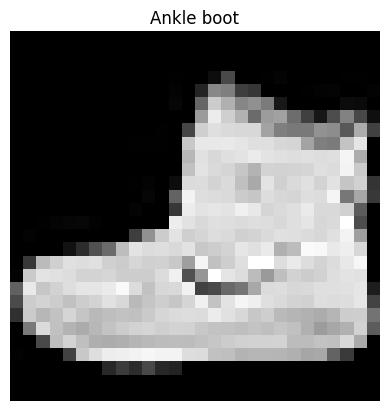

In [4]:
# Now visualize our images!! Become one with the data

data = train_dataset.data
targets = train_dataset.targets

print(f"data[0].shape: {data[0].shape}")
print(f"Target : {train_dataset.classes[targets[0]]}")

image, labe = train_dataset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_dataset.classes[targets[0]])
plt.axis(False);


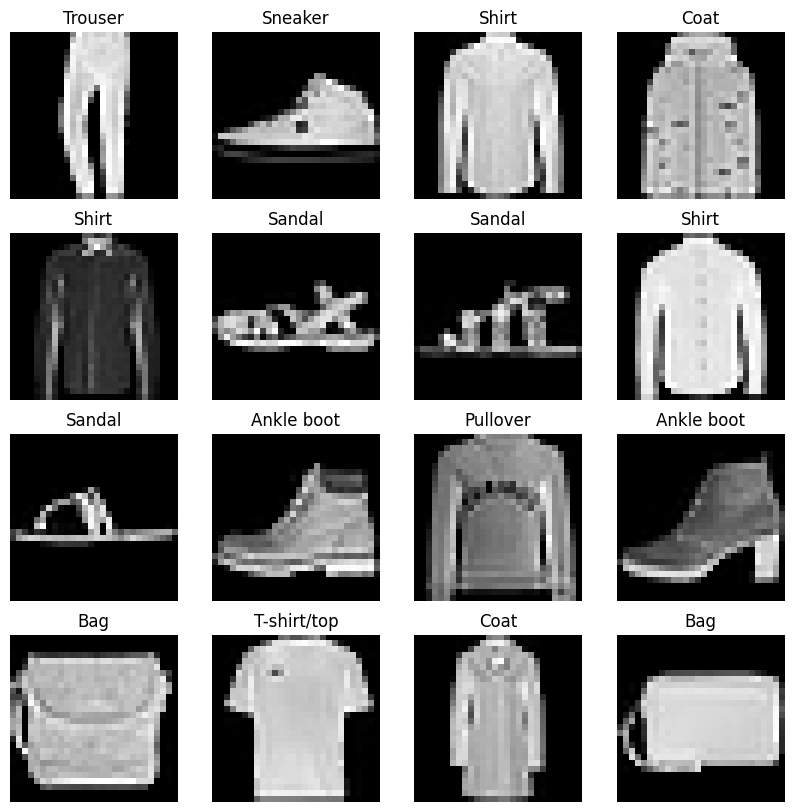

In [5]:
# Let's plot more images
torch.manual_seed(RAND_SEED)
class_names = train_dataset.classes
fig = plt.figure(figsize=(10,10))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);


### DataLoad

The data is a pytorch dataset object

DataLoader turns it into a Python iterable.

This will allow us to turn out data into minibates

Why?
* More computationally efficient. You can optimize this with respect to the GPU memory
* Andrew Ng - minibatch gradient descent


In [6]:
# Prepare dataloader!
from torch.utils.data import DataLoader

BS = 32

train_dl = DataLoader(dataset=train_dataset,
                      batch_size=BS,
                      shuffle=True,
                      )
test_dl = DataLoader(dataset=test_dataset,
                     batch_size=BS,
                     shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dl))

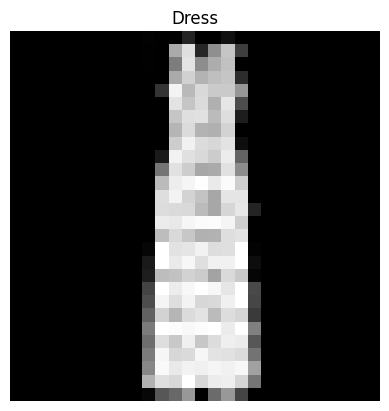

In [7]:
# Check out what is inside the dataloaded data
#torch.manual_seed(RAND_SEED)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);

### Model 0: Build a baseline model

When starting to build a series of ML modelling experiments, it's best practice to start with a baseline model

This model will then be tweeked to find improvements and experiment between hyperparams

In [8]:
# Create a flatten layer
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"x.shape: {x.shape}")
print(f"output.shape: {output.shape}")


x.shape: torch.Size([1, 28, 28])
output.shape: torch.Size([1, 784])


In [9]:
class FashMNISTV0(nn.Module):
    def __init__(self,
                 in_shape: int,
                 hidden_units: int,
                 out_shape: int,
                 device: torch.device ) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                         nn.Linear(in_features=in_shape, out_features=hidden_units),
                                         nn.ReLU(),
                                         nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                         nn.ReLU(),
                                         nn.Linear(in_features=hidden_units, out_features=out_shape)).to(device)
    def forward(self, x):
        return self.layer_stack(x)
    
torch.manual_seed(RAND_SEED)
model0 = FashMNISTV0(in_shape=784,
                     hidden_units=512,
                     out_shape=10,
                     device=device)


In [10]:
from helper_functions import accuracy_fn
# Set up loss function, optimizer, and evaluation metrics

# Since we are making a multiclass classification model we will use cross entropy loss
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.AdamW(params=model0.parameters(), lr=LR)



#### Progress bar!
The package tqdm contains python tools for displaying progress bars

In [11]:
from helper_functions import print_train_time
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Set the see and start the timer

torch.manual_seed(RAND_SEED)
train_time_start = timer()

epochs = EPOCHS
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------------")

    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dl):
        model0.train()
        # Forward Pass
        train_pred = model0(X)
        # Calculate the loss
        loss = loss_fn(train_pred, y)
        train_loss += loss
        # Optimize the zero grad
        optim.zero_grad()
        # Loss Backward
        loss.backward()
        # Optimizer step
        optim.step()
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dl.dataset)} samples.")
    # Divide total train loss by length of train_dl
    train_loss /= len(train_dl)

    ### Testing
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X,y in test_dl:
            # Forward pass
            test_pred = model0(X)
            # Calculate the loss
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        # Calculate the test loss
        test_loss /= len(test_dl)
        # Calculate the test acc
        test_acc /= len(test_dl)
    # Print out what's happening
    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\nDevice: {device}\n")

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end, device =device)


0it [00:00, ?it/s]


Train time on cpu: 0.003 seconds


In [12]:
from helper_functions import print_train_time
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Set the see and start the timer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RAND_SEED)
train_time_start = timer()

epochs = EPOCHS 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------------")

    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dl):
        X.to(device)
        y.to(device)
        model0.train()
        # Forward Pass
        train_pred = model0(X)
        # Calculate the loss
        loss = loss_fn(train_pred, y)
        train_loss += loss
        # Optimize the zero grad
        optim.zero_grad()
        # Loss Backward
        loss.backward()
        # Optimizer step
        optim.step()
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dl.dataset)} samples.")
    # Divide total train loss by length of train_dl
    train_loss /= len(train_dl)

    ### Testing
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X,y in test_dl:
            # Forward pass
            X.to(device)
            y.to(device)
            test_pred = model0(X)
            # Calculate the loss
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        # Calculate the test loss
        test_loss /= len(test_dl)
        # Calculate the test acc
        test_acc /= len(test_dl)
    # Print out what's happening
    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\nDevice: {device}\n")

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end, device = (next(model0.parameters())))

0it [00:00, ?it/s]


Train time on Parameter containing:
tensor([[-0.0304,  0.0045, -0.0311,  ...,  0.0276,  0.0149,  0.0145],
        [ 0.0200, -0.0323,  0.0318,  ..., -0.0225,  0.0031, -0.0242],
        [ 0.0289, -0.0103, -0.0308,  ...,  0.0010, -0.0345, -0.0067],
        ...,
        [-0.0025,  0.0349, -0.0196,  ..., -0.0357, -0.0112,  0.0299],
        [-0.0103,  0.0142, -0.0326,  ..., -0.0182,  0.0132,  0.0295],
        [ 0.0043,  0.0085,  0.0121,  ..., -0.0246,  0.0318, -0.0209]],
       requires_grad=True): 0.002 seconds


In [13]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    model.to(device)
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model0_results = eval_model(model=model0,
                            data_loader=test_dl,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
model0_results

100%|██████████| 313/313 [00:01<00:00, 219.66it/s]


{'model_name': 'FashMNISTV0',
 'model_loss': 2.3113107681274414,
 'model_acc': 7.178514376996805}

In [14]:
def train_step(model: nn.Module,
               data: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in data:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, pred.argmax(dim=1)) # .argmax(dim=1) goes from logits to predicted index
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data)
    train_acc /= len(data)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

def test_step(model: nn.Module,
              data: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y)
            test_acc += accuracy_fn(y, pred.argmax(dim=1))
        test_loss /= len(data)
        test_acc /= len(data)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

model = FashMNISTV0(in_shape=784,
                     hidden_units=512,
                     out_shape=10,
                     device=device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(params=model.parameters(), lr=LR)

epochs = 0

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------------")
    train_step(model= model,
               data = train_dl,
               loss_fn=loss_fn,
               optimizer=optim,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model= model,
              data = train_dl,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    print("\n")

0it [00:00, ?it/s]


In [15]:
model_results = eval_model(model=model,
                            data_loader=test_dl,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
model_results

100%|██████████| 313/313 [00:00<00:00, 345.48it/s]


{'model_name': 'FashMNISTV0',
 'model_loss': 2.307673215866089,
 'model_acc': 7.138578274760383}

In [16]:
# My first convolutional neural network!!

class ConvNet(nn.Module):
    """
    Model Architecture that replicates the TinyVGG found on the website - https://poloclub.github.io/cnn-explainer/
    Other popular models - https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

    """
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), # Values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, # There's a trick to calculating this. Make sure you build in print statements in the forward pass between blocks to follow shape, this will help you define the necessary in_shape of this layer
                      out_features=out_shape)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        #print(f"Conv1 Layer: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Conv2 Layer: {x.shape}")
        x = self.classifier(x)
        #print(f"Classifier Layer: {x.shape}")
        return x


In [17]:
# Stepping through nn.Conv2d - make some dummy data
torch.manual_seed(RAND_SEED)
images = torch.rand(size = (32,3,64,64)) # 32 in a batch, 3 color channels, 64 width, 64 height
test_image = images[0].unsqueeze(0)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
conv_out = conv_layer(test_image)
conv_out.shape

torch.Size([1, 10, 62, 62])

In [18]:
# Stepping through nn.MaxPool2d
pool_layer = nn.MaxPool2d(kernel_size=2)
conv_out = conv_layer(test_image)
print(conv_out.shape)
conv_out = pool_layer(conv_out)
conv_out.shape

torch.Size([1, 10, 62, 62])


torch.Size([1, 10, 31, 31])

torch.Size([1, 28, 28])

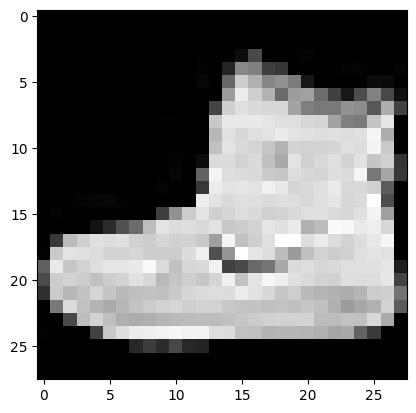

In [19]:
# Test our CNN with a Fashion MNIST image

plt.imshow(image.squeeze(), cmap='gray')
#image = image.unsqueeze(0)
image.shape

In [20]:
torch.manual_seed(RAND_SEED)
cnn_model=ConvNet(in_shape=1, hidden_units=10, out_shape=10).to(device)
torch.manual_seed(RAND_SEED)
rand_image_tensor = torch.rand(size=(1,1,28,28)).to(device)

cnn_model(rand_image_tensor)

tensor([[ 0.0178,  0.0465,  0.1109, -0.0417, -0.0021, -0.0328, -0.0627,  0.0317,
          0.0153,  0.0401]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Begin to train first CNN!

Set up a loss function and optimizer for the CNN model then build a train/test loop then evaluate the model!

In [21]:
from helper_functions import accuracy_fn
from timeit import default_timer as timer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=cnn_model.parameters(), lr=0.01)

torch.manual_seed(RAND_SEED)
torch.cuda.manual_seed(RAND_SEED)

train_time_start = timer()

epochs=6
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------")
    train_step(model=cnn_model,
              data=train_dl,
              loss_fn=loss_fn,
              optimizer=optim,
              accuracy_fn=accuracy_fn,
              device=device
              )
    test_step(model=cnn_model,
              data=test_dl,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end,device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
-----------
Train Loss: 0.48840 | Train Acc: 82.17%


 17%|█▋        | 1/6 [00:10<00:53, 10.73s/it]

Test Loss: 0.40413 | Test Acc: 85.09%
Epoch: 1
-----------
Train Loss: 0.37889 | Train Acc: 86.29%


 33%|███▎      | 2/6 [00:21<00:44, 11.02s/it]

Test Loss: 0.39696 | Test Acc: 85.64%
Epoch: 2
-----------
Train Loss: 0.36434 | Train Acc: 86.75%


 50%|█████     | 3/6 [00:32<00:32, 10.80s/it]

Test Loss: 0.37969 | Test Acc: 86.42%
Epoch: 3
-----------
Train Loss: 0.36423 | Train Acc: 86.78%


 67%|██████▋   | 4/6 [00:42<00:21, 10.64s/it]

Test Loss: 0.37215 | Test Acc: 86.37%
Epoch: 4
-----------
Train Loss: 0.35474 | Train Acc: 87.21%


 83%|████████▎ | 5/6 [00:53<00:10, 10.45s/it]

Test Loss: 0.38547 | Test Acc: 86.31%
Epoch: 5
-----------
Train Loss: 0.35060 | Train Acc: 87.32%


100%|██████████| 6/6 [01:02<00:00, 10.48s/it]

Test Loss: 0.37802 | Test Acc: 86.22%

Train time on cuda: 62.902 seconds


In [22]:
# Get cnn_model results
cnn_model_results = eval_model(model=cnn_model,
                               data_loader=test_dl,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)
cnn_model_results

100%|██████████| 313/313 [00:00<00:00, 314.56it/s]


{'model_name': 'ConvNet',
 'model_loss': 0.3780212700366974,
 'model_acc': 86.22204472843451}

In [23]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

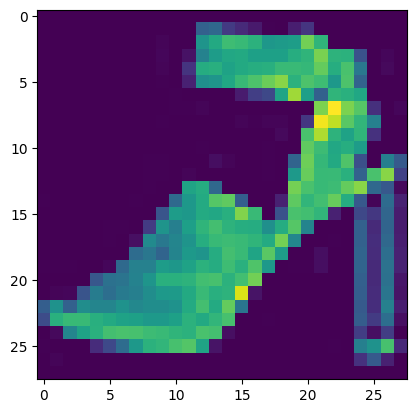

In [24]:
import random
random.seed(RAND_SEED)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=20):
    test_samples.append(sample)
    test_labels.append(label)

plt.imshow(test_samples[0].squeeze())

In [25]:
pred_probs = make_predictions(model=cnn_model,
                              data=test_samples,
                              device=device)
for i in range(len(pred_probs)):
    print(f"pred_probs[{i}]: {pred_probs[i].argmax(dim=0) == test_labels[i]}")



pred_probs[0]: True
pred_probs[1]: True
pred_probs[2]: True
pred_probs[3]: True
pred_probs[4]: True
pred_probs[5]: True
pred_probs[6]: True
pred_probs[7]: True
pred_probs[8]: True
pred_probs[9]: True
pred_probs[10]: True
pred_probs[11]: True
pred_probs[12]: True
pred_probs[13]: True
pred_probs[14]: True
pred_probs[15]: False
pred_probs[16]: True
pred_probs[17]: True
pred_probs[18]: True
pred_probs[19]: True


### Making a confusion matrix

Confusion matrix is a fantastic way to evaluate a model

Use torchmetrics - torchmetrics.ConfusionMatrix
Plot the confusion matrix using - mlxtend.plotting.plot_confusion_matrix()


In [26]:
y_preds = []
cnn_model.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dl, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = cnn_model(X)
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)
len(y_preds_tensor)

Making predictions...: 100%|██████████| 313/313 [00:00<00:00, 336.27it/s]


10000

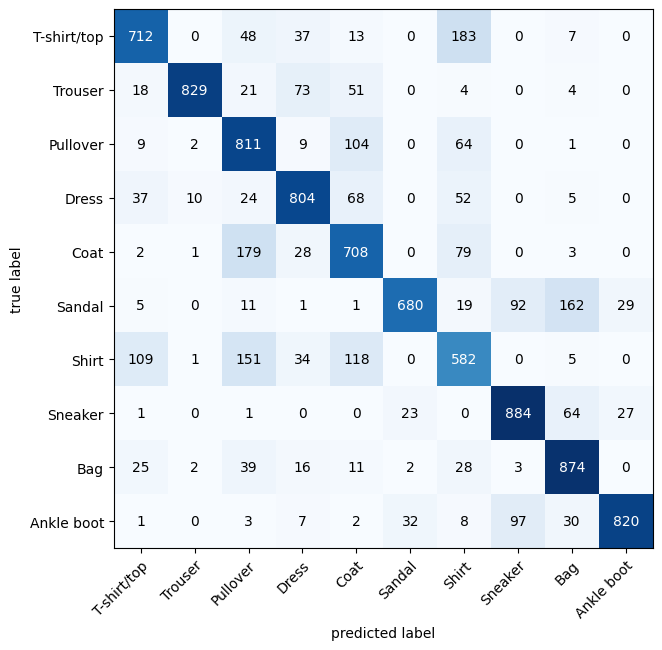

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_dataset.targets)
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,7))

In [28]:
# Save and load model!
from pathlib import Path
MODEL_PATH = Path("cnn_model")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=cnn_model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: cnn_model/cnn_model.pth


In [29]:
# Create a new instance of cnn_model

torch.manual_seed(RAND_SEED)
loaded_cnn_model = ConvNet(in_shape=1, hidden_units=10, out_shape=len(class_names))
loaded_cnn_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_cnn_model.to(device)

cnn_model_results

{'model_name': 'ConvNet',
 'model_loss': 0.3780212700366974,
 'model_acc': 86.22204472843451}

In [30]:
torch.manual_seed(RAND_SEED)
loaded_cnn_model_results = eval_model(model=loaded_cnn_model, data_loader=test_dl, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
loaded_cnn_model_results

100%|██████████| 313/313 [00:00<00:00, 335.09it/s]


{'model_name': 'ConvNet',
 'model_loss': 0.3780212700366974,
 'model_acc': 86.22204472843451}

In [31]:
# Check if models are close
torch.isclose(torch.tensor(cnn_model_results["model_loss"]),
              torch.tensor(loaded_cnn_model_results["model_loss"]),
              atol=1E-14)

tensor(True)

In [32]:
# This is code from https://horace.io/brrr_intro.html
# This is demonstrating the different regimes a deep learning neural network can be in
# - Compute, - Memory, - Overhead
# So this demonstrates the relationship between scale of computation and where the bottlenecks are.
# Are they due to GPU limitations, memory bandwidth or CPU limitations.


import torch
import time

values = []
def calc_flops(func, sz, loop_iters):
  inputs = [torch.randn(sz, device='cuda')]
  for _ in range(5):
    func(*inputs)
  torch.cuda.synchronize()
  iters = 100
  begin = time.time()
  for _ in range(iters):
    func(*inputs)
  torch.cuda.synchronize()
  t = (time.time()-begin)
  iters_per_s = iters/t
  flops = sz * loop_iters
  bytes_per_elem = 4
  num_reads = 1
  num_writes = 1
  mem_bw = sz * (num_reads + num_writes) * bytes_per_elem
  print(f"{loop_iters} ops")
  print(f"itr time: {t *1e6 / iters}")
  print(f"FLOPS: {iters_per_s * flops/1e12:.2f} TF/s")
  print(f"Mem B/W: {iters_per_s * mem_bw/1e9:.2f} GB/s")
  print()
  values.append((t / iters, iters_per_s * flops, iters_per_s * mem_bw))

for iters in [2**i for i in range(10)]:
  def f(x):
    for _ in range(iters):
      x = x * 2
    return x

  sz = 2**24
  f = torch.jit.trace(f, (torch.randn(sz, device='cuda')))
  with torch.jit.fuser("fuser2"):
    calc_flops(f, sz, iters)
    print(values)


1 ops
itr time: 797.3265647888184
FLOPS: 0.02 TF/s
Mem B/W: 168.33 GB/s

[(0.0007973265647888184, 21041837486.55565, 168334699892.4452)]
2 ops
itr time: 806.7774772644043
FLOPS: 0.04 TF/s
Mem B/W: 166.36 GB/s

[(0.0007973265647888184, 21041837486.55565, 168334699892.4452), (0.0008067774772644043, 41590690054.679405, 166362760218.71762)]
4 ops
itr time: 807.0135116577148
FLOPS: 0.08 TF/s
Mem B/W: 166.31 GB/s

[(0.0007973265647888184, 21041837486.55565, 168334699892.4452), (0.0008067774772644043, 41590690054.679405, 166362760218.71762), (0.0008070135116577149, 83157051313.98521, 166314102627.97043)]
8 ops
itr time: 805.5305480957031
FLOPS: 0.17 TF/s
Mem B/W: 166.62 GB/s

[(0.0007973265647888184, 21041837486.55565, 168334699892.4452), (0.0008067774772644043, 41590690054.679405, 166362760218.71762), (0.0008070135116577149, 83157051313.98521, 166314102627.97043), (0.0008055305480957031, 166620283137.98215, 166620283137.98215)]
16 ops
itr time: 806.4723014831543
FLOPS: 0.33 TF/s
Mem B/W: 166

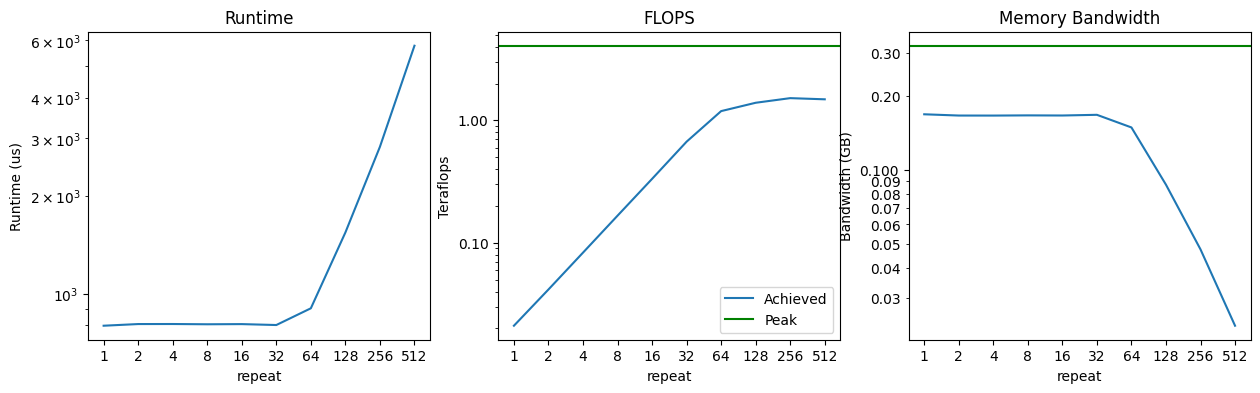

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
times, flops, mem_bw = zip(*values)
peak_tflops = 8.141/2
peak_bw = 0.32

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(15,4))

plt.subplot(gs[0])
plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Runtime (us)')
plt.plot([str(2**i) for i in range(len(times))], [i * 1e6 for i in times])
plt.title("Runtime")
# plt.show()

plt.subplot(gs[1])

peak = plt.axhline(peak_tflops, color = 'g')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Teraflops')
res, = plt.plot([str(2**i) for i in range(len(flops))], [i/1e12 for i in flops])
ax = plt.gca()
import matplotlib.ticker as mticker
plt.legend([res, peak], ['Achieved', 'Peak'])

plt.title("FLOPS")
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())


plt.subplot(gs[2])
peak = plt.axhline(peak_bw, color = 'g')

plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Bandwidth (GB)')
plt.plot([str(2**i) for i in range(len(mem_bw))], [i/1e12 for i in mem_bw])
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

import matplotlib.ticker as mticker

plt.title("Memory Bandwidth")
plt.savefig('microbench.png', bbox_inches='tight')